In [4]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [5]:
import numpy as np

import pandas as pd 

import scipy.misc      

from sklearn.model_selection import train_test_split

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files

print("import complete")

import complete


In [6]:
URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"

x_train_raw = np.loadtxt(URL_ENDPOINT+"train_x.csv", delimiter=",")
y_train_raw = np.loadtxt(URL_ENDPOINT+"train_y.csv", delimiter=",")
x_test_raw  = np.loadtxt(URL_ENDPOINT+"test_x.csv", delimiter=",")

print("data load complete")

data load complete


In [0]:
USE_CUDA = True    # set to false to use CPU
CUDA_AVAIL = torch.cuda.is_available()

VALID_SPLIT = 0.2

NUM_EPOCH = 50
BATCH_SIZE = 25
LEARN_RATE = 0.0001

In [10]:
# preprocessing and formatting
x_train = np.floor(np.divide(x_train_raw, 255)).reshape(-1, 64, 64)
y_train = y_train_raw.reshape(-1)
x_test  = np.floor(np.divide(x_test_raw, 255)).reshape(-1, 64, 64)

# training-validation split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=VALID_SPLIT)   

x_train = torch.from_numpy(x_train).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()

x_valid = torch.from_numpy(x_valid).float().unsqueeze(1)
y_valid = torch.from_numpy(y_valid).long()

x_test  = torch.from_numpy(x_test).float().unsqueeze(1)

print("processing complete")

processing complete


In [11]:
# create torch dataset and dataloader
train_dataset = Data.TensorDataset(x_train, y_train)
train_loader  = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = Data.TensorDataset(x_valid, y_valid)
valid_loader  = Data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader   = Data.DataLoader(x_test, batch_size=BATCH_SIZE, shuffle=False)

print("created dataset and dataloader")

created dataset and dataloader


In [0]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Sequential(       # input shape (1, 64, 64)
      nn.Conv2d(
          in_channels=1,              # input height
          out_channels=16,            # n_filters
          kernel_size=5,              
          stride=1,                   
          padding=2,                  
      ),                              # output shape (16, 64, 64)
      nn.BatchNorm2d(16),
      nn.ReLU(),                      # activation
      nn.Conv2d(16, 16, 4, 1, 2),     # output shape (32, 32, 32)  
      nn.BatchNorm2d(16),                           
      nn.ReLU(),                    
      nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 32, 32)
      nn.Dropout2d(0.20)              
    )

    self.conv2 = nn.Sequential(       # input shape (1, 64, 64)
      nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 32, 32)
      nn.BatchNorm2d(32), 
      nn.ReLU(),                      # activation
      nn.Conv2d(32, 32, 4, 1, 2),     # output shape (32, 32, 32)  
      nn.BatchNorm2d(32),                          
      nn.ReLU(),                   
      nn.MaxPool2d(2),                # output shape (32, 16, 16)
      nn.Dropout2d(0.30)              
    )
    
    self.conv3 = nn.Sequential(       # input shape (1, 64, 64)
      nn.Conv2d(32, 64, 5, 1, 2),     # output shape (64, 16, 16)
      nn.BatchNorm2d(64), 
      nn.ReLU(),                      # activation   
      nn.Conv2d(64, 64, 4, 1, 2),     # output shape (64, 16, 16)
      nn.BatchNorm2d(64), 
      nn.ReLU(),
      nn.MaxPool2d(2),                # output shape (64, 8, 8)
      nn.Dropout2d(0.40)
    )
    
    self.conv4 = nn.Sequential(       # input shape (1, 64, 64)
      nn.Conv2d(64, 128, 5, 1, 2),     # output shape (128, 8, 8)
      nn.BatchNorm2d(128), 
      nn.ReLU(),                      # activation   
      nn.Conv2d(128, 128, 4, 1, 2),     # output shape (128, 8, 8)
      nn.BatchNorm2d(128), 
      nn.ReLU(),
      nn.MaxPool2d(2),                # output shape (128, 4, 4)
      nn.Dropout2d(0.50)
    )
    
    self.out = nn.Linear(128 * 4 * 4, 10)   # fully connected layer, output 10 classes

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 16 * 16)
    output = self.out(x)
    return output

In [13]:
cnn = CNN()

if USE_CUDA and CUDA_AVAIL:
  cnn.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARN_RATE)

print("created model, optimizer")

created model, optimizer


In [14]:
# train the model
start_time = time.time()
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

for epoch in range(NUM_EPOCH):
  
  for i, (images, labels) in enumerate(train_loader):
    if USE_CUDA and CUDA_AVAIL:
      images, labels = images.cuda(), labels.cuda()
    images, labels = Variable(images), Variable(labels)
      
    # forward + backward + optimize
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # at end of every epoch
    if i == len(train_loader) - 1:
      cnn.eval()
      
      # store training model loss
      train_losses.append(loss.data[0])
      
      # store validation model loss
      loader  = Data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
      
      for j, (images, labels) in enumerate(loader):
        if USE_CUDA and CUDA_AVAIL:
          images, labels = images.cuda(), labels.cuda()
        images, labels = Variable(images, volatile=True), Variable(labels, volatile=True)

        outputs = cnn(images)
        valid_loss = criterion(outputs, labels)
        
        if j == len(loader) - 1:
          valid_losses.append(valid_loss.data[0])
      
      # store accuracy on training set
      correct = 0
      total = 0
      
      loader  = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
      
      for j, (images, labels) in enumerate(loader):
        if USE_CUDA and CUDA_AVAIL:
          images = images.cuda()
        images = Variable(images, volatile=True)

        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        
      train_acc.append(100 * correct / total)
      
      # store accuracy on validation set
      loader  = Data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
      for j, (images, labels) in enumerate(loader):
        if USE_CUDA and CUDA_AVAIL:
          images = images.cuda()
        images = Variable(images, volatile=True)

        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        
      valid_acc.append(100 * correct / total)

      cnn.train()
      
print("Model trained in --- %s seconds ---" % (time.time() - start_time))

Model trained in --- 3891.074508190155 seconds ---


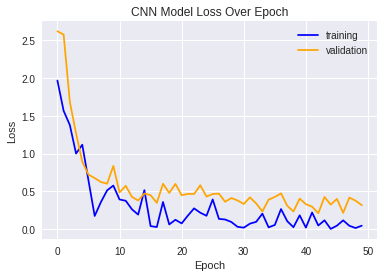

In [21]:
# plot and download model loss
plt.plot(train_losses, 'b')
plt.plot(valid_losses, 'orange')
# plt.ylim(0, 1)
plt.title('CNN Model Loss Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()
# plt.savefig('cnnModelLoss.png')
# files.download('cnnModelLoss.png')

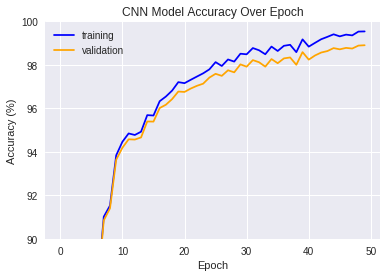

In [22]:
# plot and download model accuracy
plt.plot(train_acc, 'b')
plt.plot(valid_acc, 'orange')
plt.ylim(90, 100)
plt.title('CNN Model Accuracy Over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['training', 'validation'])
plt.show()
# plt.savefig('cnnModelAccuracy.png')
# files.download('cnnModelAccuracy.png')

In [23]:
# get accuracy on validation set
cnn.eval()

correct = 0
total = 0

for i, (images, labels) in enumerate(valid_loader):
  if USE_CUDA and CUDA_AVAIL:
    images = images.cuda()
  images = Variable(images)
 
  outputs = cnn(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted.cpu() == labels).sum()

print('Accuracy of the model on validation set: %d %%' % (100 * correct / total))

Accuracy of the model on validation set: 96 %


In [24]:
# predict test data
cnn.eval()

predictions = []

for i, images in enumerate(test_loader):
  if USE_CUDA and CUDA_AVAIL:
    images = images.cuda()
  images = Variable(images)
  
  outputs = cnn(images)
  y_pred_batch = torch.max(outputs.cpu(), 1)[1].data.numpy().squeeze()

  predictions.append(y_pred_batch)
  
predictions = pd.DataFrame([item for sublist in predictions for item in sublist])

print("predictions complete")

predictions complete


In [25]:
# create and download .csv file (formatted for Kaggle submission) for predictions on test data
predictions.to_csv("cnn_pred.csv", index_label='Id', header=['Label'])
files.download("cnn_pred.csv")

print("download complete")

download complete
